In [60]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
#plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [2]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_sal_0808.dat'

# 예측 결과를 저장할 파일 이름
prediction_path = 'model/pitcher_prediction_final_0813.csv'

### 저장한 모델 객체 등을 복원한다.

In [3]:
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

test_model = loaded['model']
test_encoder = loaded.get('encoder')
test_scaler = loaded.get('scaler')

In [4]:
display(test_model)
display(test_encoder)
display(test_scaler)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

LabelEncoder()

StandardScaler()

### 예측할 데이터를 준비한다.

In [5]:
df_all = pd.read_csv('투수_연봉_학습데이터.csv')

# 2024만 추출
df_pred = df_all[df_all['연도'] == 2024].copy()
df_pred

,선수,포지션,WAR,G,GS,GR,GF,CG,SHO,W,...,연도,선발,중간계투,마무리,수상여부,연봉 총수령액(만원),연봉등급(만원),팀연봉순위,전체연봉순위,연봉등급(순위)
715,양현종,투수,5.01,29,29,0,3,3,0,11,...,2024,1,0,0,0,125000,A,4,33,B
716,네일,투수,4.90,26,26,0,0,0,0,12,...,2024,1,0,0,1,168000,A,2,14,A
717,정해영,투수,2.44,53,0,53,44,0,0,2,...,2024,0,0,1,1,36000,B,13,93,C
718,윤영철,투수,2.18,18,18,0,0,0,0,7,...,2024,1,0,0,0,12000,B,22,189,C
719,황동하,투수,2.13,25,21,4,4,0,0,5,...,2024,1,0,0,0,10000,B,27,213,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,김도빈,투수,-0.11,1,1,0,0,0,0,0,...,2024,0,1,0,0,3100,D,57,516,D
951,이충호,투수,-0.12,3,0,3,0,0,0,0,...,2024,0,1,0,0,3400,D,49,453,D
952,장지수,투수,-0.14,13,0,13,7,0,0,0,...,2024,0,1,0,0,3400,D,49,453,D
953,윤대경,투수,-0.26,7,0,7,1,0,0,0,...,2024,0,1,0,0,7000,C,28,264,C


In [6]:
drop_cols = ['pid','선수','포지션','팀','연봉 총수령액(만원)','연봉등급(만원)','연봉등급(순위)',
             '팀연봉순위','전체연봉순위','계약금(만원)','계약금(만원)분할','연도']
drop_cols = [c for c in drop_cols if c in df_pred.columns]

In [7]:
# 표준화를 위해 결과데이터를 제외
X_raw = df_pred.drop(columns=drop_cols)

In [8]:
X_raw

,WAR,G,GS,GR,GF,CG,SHO,W,L,S,...,ERA,RA9,rRA9,rRA9pf,FIP,WHIP,선발,중간계투,마무리,수상여부
715,5.01,29,29,0,3,3,0,11,5,0,...,4.10,4.52,4.37,4.37,4.63,1.25,1,0,0,0
716,4.90,26,26,0,0,0,0,12,5,0,...,2.53,4.16,4.06,4.04,3.68,1.27,1,0,0,1
717,2.44,53,0,53,44,0,0,2,3,31,...,2.49,2.49,3.00,2.98,4.59,1.24,0,0,1,1
718,2.18,18,18,0,0,0,0,7,4,0,...,4.19,4.85,4.70,4.61,5.26,1.53,1,0,0,0
719,2.13,25,21,4,4,0,0,5,7,0,...,4.44,5.57,5.19,5.19,5.30,1.48,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,-0.11,1,1,0,0,0,0,0,1,0,...,54.00,54.00,54.00,54.00,24.60,12.00,0,1,0,0
951,-0.12,3,0,3,0,0,0,0,0,0,...,3.86,3.86,11.76,11.02,4.97,3.00,0,1,0,0
952,-0.14,13,0,13,7,0,0,0,0,0,...,10.93,11.57,9.48,9.15,4.45,2.36,0,1,0,0
953,-0.26,7,0,7,1,0,0,0,0,0,...,10.57,10.57,11.97,11.77,6.30,2.09,0,1,0,0


In [9]:
# 1) info 테이블 (pid/선수/팀/연도)
info_pred = df_pred[['pid','선수','팀','연도']].reset_index(drop=True)
info_pred

,pid,선수,팀,연도
0,10058,양현종,KIA 타이거즈,2024
1,16088,네일,KIA 타이거즈,2024
2,14608,정해영,KIA 타이거즈,2024
3,15432,윤영철,KIA 타이거즈,2024
4,15063,황동하,KIA 타이거즈,2024
...,...,...,...,...
235,16118,김도빈,한화 이글스,2024
236,11116,이충호,한화 이글스,2024
237,14178,장지수,한화 이글스,2024
238,11110,윤대경,한화 이글스,2024


In [10]:
# 2) 학습 때 사용한 피처 리스트 확보 → 순서 맞추기
if 'features' in loaded and loaded['features'] is not None:
    features = list(loaded['features'])
elif hasattr(test_model, 'feature_names_in_'):
    features = list(test_model.feature_names_in_)
else:
    features = list(X_raw.columns)  # 최후 수단

# (선택) 누락/여분 피처 처리
missing = [c for c in features if c not in X_raw.columns]
extra   = [c for c in X_raw.columns if c not in features]
if missing:
    # 스케일러가 있으면 평균으로, 없으면 0으로 채울 예정이라 우선 컬럼만 추가
    for c in missing:
        X_raw[c] = np.nan
# 여분 컬럼은 버리고, 학습 순서로 재정렬
X_raw = X_raw.reindex(columns=features)

In [11]:
X_raw

,WAR,G,GS,GR,GF,CG,SHO,W,L,S,...,ERA,RA9,rRA9,rRA9pf,FIP,WHIP,선발,중간계투,마무리,수상여부
715,5.01,29,29,0,3,3,0,11,5,0,...,4.10,4.52,4.37,4.37,4.63,1.25,1,0,0,0
716,4.90,26,26,0,0,0,0,12,5,0,...,2.53,4.16,4.06,4.04,3.68,1.27,1,0,0,1
717,2.44,53,0,53,44,0,0,2,3,31,...,2.49,2.49,3.00,2.98,4.59,1.24,0,0,1,1
718,2.18,18,18,0,0,0,0,7,4,0,...,4.19,4.85,4.70,4.61,5.26,1.53,1,0,0,0
719,2.13,25,21,4,4,0,0,5,7,0,...,4.44,5.57,5.19,5.19,5.30,1.48,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,-0.11,1,1,0,0,0,0,0,1,0,...,54.00,54.00,54.00,54.00,24.60,12.00,0,1,0,0
951,-0.12,3,0,3,0,0,0,0,0,0,...,3.86,3.86,11.76,11.02,4.97,3.00,0,1,0,0
952,-0.14,13,0,13,7,0,0,0,0,0,...,10.93,11.57,9.48,9.15,4.45,2.36,0,1,0,0
953,-0.26,7,0,7,1,0,0,0,0,0,...,10.57,10.57,11.97,11.77,6.30,2.09,0,1,0,0


In [12]:
# 3) 숫자화 + 결측치 처리 + 스케일링
X_num = X_raw.apply(pd.to_numeric, errors='coerce')

if (test_scaler is not None) and hasattr(test_scaler, 'mean_') and len(test_scaler.mean_) == X_num.shape[1]:
    # 학습 분포에 맞춰 평균으로 메우고 스케일링
    fill_vals = dict(zip(features, test_scaler.mean_))
    X_filled = X_num.fillna(fill_vals)
    X_in = test_scaler.transform(X_filled)
else:
    # 스케일러가 없거나 차원이 다르면 0으로 메꿔서 그대로 사용
    X_in = X_num.fillna(0).values

In [13]:
# 4) 예측 + (선택) 확률
y_pred = test_model.predict(X_in)

if test_encoder is not None:
    y_label = test_encoder.inverse_transform(y_pred)
else:
    # 인코더가 없는 경우 대비 — 클래스 수에 따라 A~D/A~E 매핑
    n_cls = getattr(test_model, 'n_classes_', len(np.unique(y_pred)))
    label_map_rev = {0:'A',1:'B',2:'C',3:'D'} if n_cls==4 else {0:'A',1:'B',2:'C',3:'D',4:'E'}
    y_label = pd.Series(y_pred).map(label_map_rev).values

proba_df = None
if hasattr(test_model, 'predict_proba'):
    proba = test_model.predict_proba(X_in)
    if test_encoder is not None:
        prob_cols = [f"P({c})" for c in test_encoder.classes_]
    else:
        prob_cols = [f"P_{i}" for i in range(proba.shape[1])]
    proba_df = pd.DataFrame(proba, columns=prob_cols)

In [14]:
# 5) 결과 합치기 (예시 스타일 유지)
X_out = X_raw.copy()
X_out['연봉 등급(예측,2025)'] = y_label

final_df = pd.concat(
    [info_pred.reset_index(drop=True), X_out.reset_index(drop=True)],
    axis=1
)
if proba_df is not None:
    final_df = pd.concat([final_df, proba_df], axis=1)

In [15]:
# 컬럼명 변경
final_df.rename(columns={'연봉 등급(예측,2025)': '연봉등급'}, inplace=True)

In [16]:
final_df

,pid,선수,팀,연도,WAR,G,GS,GR,GF,CG,...,WHIP,선발,중간계투,마무리,수상여부,연봉등급,P(A),P(B),P(C),P(D)
0,10058,양현종,KIA 타이거즈,2024,5.01,29,29,0,3,3,...,1.25,1,0,0,0,B,0.203983,0.763878,0.021455,0.010683
1,16088,네일,KIA 타이거즈,2024,4.90,26,26,0,0,0,...,1.27,1,0,0,1,A,0.868287,0.126613,0.002778,0.002322
2,14608,정해영,KIA 타이거즈,2024,2.44,53,0,53,44,0,...,1.24,0,0,1,1,B,0.167488,0.818220,0.009908,0.004384
3,15432,윤영철,KIA 타이거즈,2024,2.18,18,18,0,0,0,...,1.53,1,0,0,0,B,0.053382,0.720931,0.205161,0.020526
4,15063,황동하,KIA 타이거즈,2024,2.13,25,21,4,4,0,...,1.48,1,0,0,0,B,0.028743,0.897534,0.058007,0.015715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,16118,김도빈,한화 이글스,2024,-0.11,1,1,0,0,0,...,12.00,0,1,0,0,D,0.002395,0.055338,0.079360,0.862907
236,11116,이충호,한화 이글스,2024,-0.12,3,0,3,0,0,...,3.00,0,1,0,0,D,0.003028,0.041682,0.065064,0.890226
237,14178,장지수,한화 이글스,2024,-0.14,13,0,13,7,0,...,2.36,0,1,0,0,D,0.020975,0.070229,0.276704,0.632093
238,11110,윤대경,한화 이글스,2024,-0.26,7,0,7,1,0,...,2.09,0,1,0,0,D,0.002288,0.104053,0.059662,0.833998


In [17]:
# 저장한다
final_df.to_csv(prediction_path, index=False, encoding='utf-8-sig')

In [18]:
final_df['연봉등급'].value_counts()

,count
연봉등급,
D,97
B,86
C,51
A,6


In [20]:
# 혹시 모를 공백 제거
final_df.columns = final_df.columns.str.strip()

# 팀별 예측 등급 분포 (카운트)
team_grade = (
    final_df.groupby(['팀', '연봉등급'])
            .size()
            .unstack(fill_value=0)
            .reindex(columns=['A','B','C','D'], fill_value=0)  # 원하는 순서
            .sort_index()
)
team_grade

연봉등급,A,B,C,D
팀,,,,
KIA 타이거즈,1,10,5,12
KT 위즈,1,8,5,9
LG 트윈스,0,6,10,7
NC 다이노스,0,8,2,14
SSG 랜더스,1,9,2,11
두산 베어스,1,10,5,9
롯데 자이언츠,0,8,6,9
삼성 라이온즈,0,11,5,10
키움 히어로즈,2,7,4,8


In [21]:
# 불확실 사례 TOP20 (확률 1,2위 차이 작은 케이스)
if hasattr(test_model, 'predict_proba'):
    import numpy as np, pandas as pd
    proba = test_model.predict_proba(X_in)
    top = proba.max(axis=1)
    second = np.partition(proba, -2, axis=1)[:, -2]
    margin = top - second
    borderline = (final_df
                  .assign(maxP=top, margin=margin)
                  .sort_values('margin')
                  .loc[:, ['pid','선수','팀','연봉등급','maxP','margin']]
                  .head(20))

In [22]:
borderline

,pid,선수,팀,연봉등급,maxP,margin
42,14733,최종인,두산 베어스,B,0.353619,0.009962
87,10137,송은범,삼성 라이온즈,D,0.451586,0.013217
183,15475,박윤성,키움 히어로즈,C,0.452858,0.014955
64,14624,최준용,롯데 자이언츠,C,0.406457,0.025253
28,13061,곽빈,두산 베어스,A,0.496306,0.029824
94,10730,양현,삼성 라이온즈,D,0.415834,0.031804
156,14651,이종준,LG 트윈스,C,0.459626,0.032416
168,15486,박명근,LG 트윈스,C,0.508075,0.044772
75,12930,나균안,롯데 자이언츠,B,0.407581,0.045612
187,14576,이종민,키움 히어로즈,D,0.500527,0.045662


In [31]:
# 1) 예측 결과 (앞 단계에서 만든 것)
pred = final_df[['pid','선수','팀','연봉등급']].copy()

# 2) 2025년 연봉정보 가져오기
sal25 = df_pred[['pid','선수','팀','연봉등급(만원)', '연봉 총수령액(만원)']]

display(pred)
display(sal25)

,pid,선수,팀,연봉등급
0,10058,양현종,KIA 타이거즈,B
1,16088,네일,KIA 타이거즈,A
2,14608,정해영,KIA 타이거즈,B
3,15432,윤영철,KIA 타이거즈,B
4,15063,황동하,KIA 타이거즈,B
...,...,...,...,...
235,16118,김도빈,한화 이글스,D
236,11116,이충호,한화 이글스,D
237,14178,장지수,한화 이글스,D
238,11110,윤대경,한화 이글스,D


,pid,선수,팀,연봉등급(만원),연봉 총수령액(만원)
715,10058,양현종,KIA 타이거즈,A,125000
716,16088,네일,KIA 타이거즈,A,168000
717,14608,정해영,KIA 타이거즈,B,36000
718,15432,윤영철,KIA 타이거즈,B,12000
719,15063,황동하,KIA 타이거즈,B,10000
...,...,...,...,...,...
950,16118,김도빈,한화 이글스,D,3100
951,11116,이충호,한화 이글스,D,3400
952,14178,장지수,한화 이글스,D,3400
953,11110,윤대경,한화 이글스,C,7000


In [32]:
# 1) 예측/실제 정리
pred  = final_df[['pid','팀','연봉등급']].copy().rename(columns={'연봉등급':'pred'})       # 예측
truth = df_pred[['pid','팀','연봉등급(만원)','연봉 총수령액(만원)']].copy()                 # 실제 2025
truth = truth.rename(columns={'연봉등급(만원)':'true', '연봉 총수령액(만원)':'연봉총(만원)'})

# (안전) pid 중복 제거
pred  = pred.drop_duplicates('pid')
truth = truth.drop_duplicates('pid')

In [33]:
# 2) 매칭
eval_df = pred.merge(truth, on=['pid'], how='inner')  # 팀 변동 가능하니 pid 기준 권장

In [36]:
# 3) 혼동행렬/리포트
labels = ['A','B','C','D']   # 사용한 등급 셋에 맞춰 조정
cm = confusion_matrix(eval_df['true'], eval_df['pred'], labels=labels)
cm_df = pd.DataFrame(cm, index=[f'실제:{l}' for l in labels],
                         columns=[f'예측:{l}' for l in labels])
print(cm_df)
print(classification_report(eval_df['true'], eval_df['pred'],
                            labels=labels, digits=3))

      예측:A  예측:B  예측:C  예측:D
실제:A     5    17     0     2
실제:B     1    51    21     4
실제:C     0    13    18    18
실제:D     0     5    12    73
              precision    recall  f1-score   support

           A      0.833     0.208     0.333        24
           B      0.593     0.662     0.626        77
           C      0.353     0.367     0.360        49
           D      0.753     0.811     0.781        90

    accuracy                          0.613       240
   macro avg      0.633     0.512     0.525       240
weighted avg      0.628     0.613     0.600       240



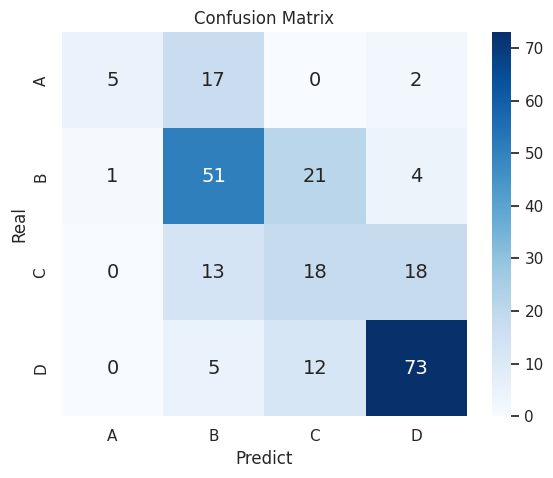

In [66]:
cm = confusion_matrix(eval_df['true'], eval_df['pred'], labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{l}" for l in labels],
            yticklabels=[f"{l}" for l in labels])
plt.xlabel("Predict")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [75]:
# 1) 오분류만 추출
miss = eval_df.loc[eval_df['true'] != eval_df['pred']].copy()

# 2) 등급 차이(순서형 거리) 계산: A> B> C> D 를 3,2,1,0으로 매핑
ord_map = {'A':3,'B':2,'C':1,'D':0}
miss['등급차'] = (miss['true'].map(ord_map) - miss['pred'].map(ord_map)).abs()

# 3) 보기 좋은 컬럼만 정리 (있을 때만 포함)
cols_want = ['pid','선수','팀','true','pred','연봉총(만원)','등급차']
cols = [c for c in cols_want if c in miss.columns]
miss_view = miss[cols].sort_values(['등급차','pid'], ascending=[False, True])

miss_view

,pid,true,pred,연봉총(만원),등급차
111,10131,A,D,110000,3
182,11161,A,D,62500,3
239,10609,B,D,47000,2
115,11373,B,D,20500,2
177,14480,D,B,4500,2
...,...,...,...,...,...
220,16107,D,C,4500,1
233,16108,D,C,4000,1
185,16127,D,C,3800,1
218,16153,A,B,84000,1


In [85]:
df_merge = pd.merge(miss_view, sal25, on='pid', how='left')
df_merge.drop(columns=['연봉등급(만원)', '연봉 총수령액(만원)'], inplace=True)

In [86]:
cols = list(df_merge.columns)
front = [c for c in ['선수', '팀'] if c in cols]
rest  = [c for c in cols if c not in front]

df_merge = df_merge[front + rest]
df_merge

,선수,팀,pid,true,pred,연봉총(만원),등급차
0,박종훈,SSG 랜더스,10131,A,D,110000,3
1,원종현,키움 히어로즈,11161,A,D,62500,3
2,이태양,한화 이글스,10609,B,D,47000,2
3,김택형,SSG 랜더스,11373,B,D,20500,2
4,김인범,키움 히어로즈,14480,D,B,4500,2
...,...,...,...,...,...,...,...
88,황준서,한화 이글스,16107,D,C,4500,1
89,조동욱,한화 이글스,16108,D,C,4000,1
90,김연주,키움 히어로즈,16127,D,C,3800,1
91,와이스,한화 이글스,16153,A,B,84000,1


In [88]:
df_merge.to_csv('투수연봉예측_실패칼럼_0813.csv', index=False)

In [90]:
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

os.makedirs('export', exist_ok=True)
labels = ['A','B','C','D']  # 실제 라벨에 맞춰 조정

# ── 2-1. 혼동행렬 저장 (건수 / 행기준 정규화) ──────────────────────────────
cm = confusion_matrix(eval_df['true'], eval_df['pred'], labels=labels)

def save_cm(cm, labels, title, path, norm=None):
    m, fmt = (cm / (cm.sum(axis=1, keepdims=True)+1e-9), '.2f') if norm=='true' else (cm, 'd')
    plt.figure(figsize=(6,5))
    sns.heatmap(m, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("예측 등급"); plt.ylabel("실제 등급"); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=220); plt.close()

save_cm(
    cm, labels,
    '혼동행렬 (건수 기준)',
    'export/혼동행렬_건수기준_2024스탯기반_2025연봉등급예측_전체선수.png'
)
save_cm(
    cm, labels,
    '혼동행렬 (행 기준 정규화 비율)',
    'export/혼동행렬_행기준정규화비율_2024스탯기반_2025연봉등급예측_전체선수.png',
    norm='true'
)

# ── 2-2. 오분류만 히트맵(대각선 제외) ─────────────────────────────────────
off = pd.crosstab(eval_df['true'], eval_df['pred']).reindex(index=labels, columns=labels, fill_value=0)
np.fill_diagonal(off.values, 0)
plt.figure(figsize=(6,5))
sns.heatmap(off, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('예측 등급'); plt.ylabel('실제 등급'); plt.title('오분류 분포 (정답≠예측)')
plt.tight_layout()
plt.savefig('export/오분류분포_정답≠예측_2024스탯기반_2025연봉등급예측.png', dpi=220)
plt.close()

# ── 2-3. 오분류 상위 20명 표를 이미지로 ───────────────────────────────────
# df_merge: [선수, 팀, pid, true, pred, 연봉총(만원), 등급차]
miss_top = (df_merge[df_merge['true']!=df_merge['pred']]
            .sort_values(['등급차','연봉총(만원)'], ascending=[False, False])
            .head(20).copy())
miss_top['연봉(표시)'] = miss_top['연봉총(만원)'].map('{:,.0f}'.format)
tbl = miss_top[['선수','팀','true','pred','등급차','연봉(표시)']]

fig, ax = plt.subplots(figsize=(9, 0.42*len(tbl)+1))
ax.axis('off')
table = ax.table(cellText=tbl.values,
                 colLabels=['선수','팀','실제등급','예측등급','등급차','연봉(만원)'],
                 loc='center')
table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1, 1.35)
plt.tight_layout()
plt.savefig('export/오분류상위20명_선수팀_실제vs예측_등급차_연봉표_이미지.png', dpi=220)
plt.close()

# (표 CSV도 저장해두면 PPT에 붙이기 쉬움)
miss_top.rename(columns={'true':'실제등급','pred':'예측등급','연봉(표시)':'연봉표시'}) \
        .to_csv('export/오분류상위20명_표데이터.csv', index=False, encoding='utf-8-sig')

# ── 2-4. 팀별 오분류 스택바 ────────────────────────────────────────────────
stack = (df_merge[df_merge['true']!=df_merge['pred']]
         .groupby(['팀','pred']).size().unstack(fill_value=0)
         .reindex(columns=labels, fill_value=0))
ax = stack.plot(kind='bar', stacked=True, figsize=(9,4))
ax.set_xlabel('팀'); ax.set_ylabel('오분류 건수'); ax.set_title('팀별 오분류 분포 (예측 등급 기준)')
ax.legend(title='예측등급', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.savefig('export/팀별오분류_스택바_예측등급기준_2024스탯기반_2025연봉등급예측.png', dpi=220)
plt.close()

# ── 2-5. 발표용 핵심 수치 텍스트 ──────────────────────────────────────────
print(classification_report(eval_df['true'], eval_df['pred'], labels=labels, digits=3))

              precision    recall  f1-score   support

           A      0.833     0.208     0.333        24
           B      0.593     0.662     0.626        77
           C      0.353     0.367     0.360        49
           D      0.753     0.811     0.781        90

    accuracy                          0.613       240
   macro avg      0.633     0.512     0.525       240
weighted avg      0.628     0.613     0.600       240



### 예측값 수정해보기?

              precision    recall  f1-score   support

           A      0.857     0.250     0.387        24
           B      0.662     0.610     0.635        77
           C      0.337     0.673     0.449        49
           D      0.812     0.578     0.675        90

    accuracy                          0.575       240
   macro avg      0.667     0.528     0.537       240
weighted avg      0.672     0.575     0.587       240



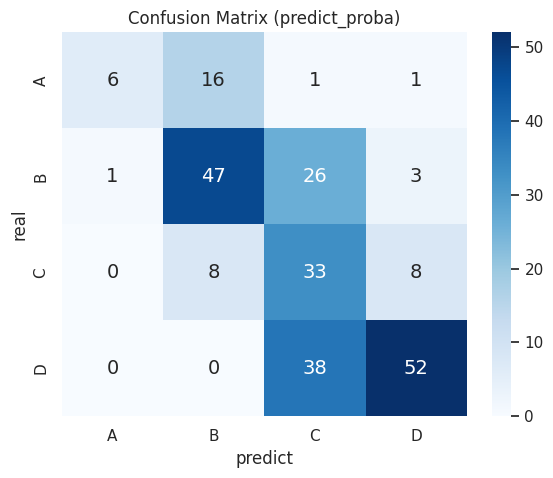

In [70]:
labels = ['A','B','C','D']
order  = {l:i for i,l in enumerate(labels)}  # A0,B1,C2,D3  (순서형)

# 비용행렬: 거리^2 + A/C 패널티(가중치 튜닝 가능)
K = len(labels)
L = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        L[i,j] = (i-j)**2
# A,C 틀리면 추가 패널티
for i in [order['A'], order['C']]:
    for j in range(K):
        if i != j:
            L[i,j] += 0.5  # 0~1 사이 값으로 조절해가며 테스트

# 예측 확률
proba = test_model.predict_proba(X_in)  # X_in: 예측에 쓴 입력(스케일 적용된 것)

# 기대비용 최소 의사결정
# 각 샘플에 대해 decision j의 기대비용 = sum_i P(true=i|x) * L[i,j]
# => row_proba (1xK) @ L (KxK) = (1xK)
cost = proba @ L
dec  = cost.argmin(axis=1)
pred_cost = [labels[j] for j in dec]

# 평가
print(classification_report(eval_df['true'], pred_cost, labels=labels, digits=3))
cm2 = confusion_matrix(eval_df['true'], pred_cost, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("predict");
plt.ylabel("real")
plt.title("Confusion Matrix (predict_proba)"); plt.tight_layout(); plt.show()

              precision    recall  f1-score   support

           A      0.833     0.208     0.333        24
           B      0.593     0.662     0.626        77
           C      0.353     0.367     0.360        49
           D      0.753     0.811     0.781        90

    accuracy                          0.613       240
   macro avg      0.633     0.512     0.525       240
weighted avg      0.628     0.613     0.600       240



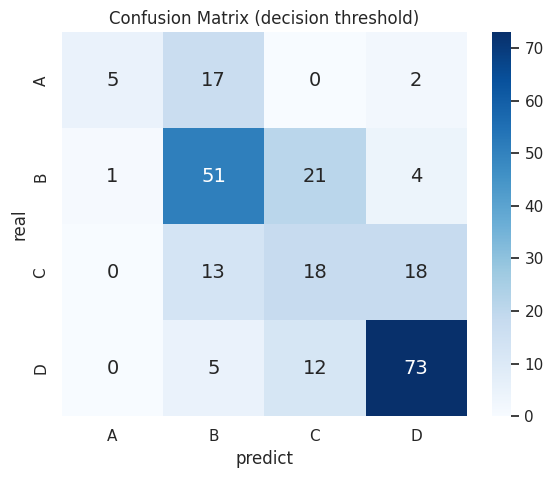

In [74]:
thrA, thrD = 0.35, 0.45  # 검증셋으로 튜닝 권장
p = proba  # 위에서 계산한 확률

argmax = p.argmax(axis=1)
base   = np.array([labels[i] for i in argmax])

fix    = base.copy()
# A 우선 규칙
fix[(p[:, order['A']] >= thrA) & (p[:, order['A']] >= p.max(axis=1))] = 'A'
# D 우선 규칙
fix[(p[:, order['D']] >= thrD) & (p[:, order['D']] >= p.max(axis=1))] = 'D'

print(classification_report(eval_df['true'], fix, labels=labels, digits=3))
cm3 = confusion_matrix(eval_df['true'], fix, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("predict")
plt.ylabel("real")
plt.title("Confusion Matrix (decision threshold)"); plt.tight_layout(); plt.show()